In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.datasets import mnist

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
class SimpleAutoencoder(Model):
    def __init__(self, latent_dimensions):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(28 * 28, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])

    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
latent_dimensions = 64
autoencoder = SimpleAutoencoder(latent_dimensions)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError()

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0968 - val_loss: 0.0320
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0289 - val_loss: 0.0208
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0196 - val_loss: 0.0150
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0115
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0092
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0077
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0050


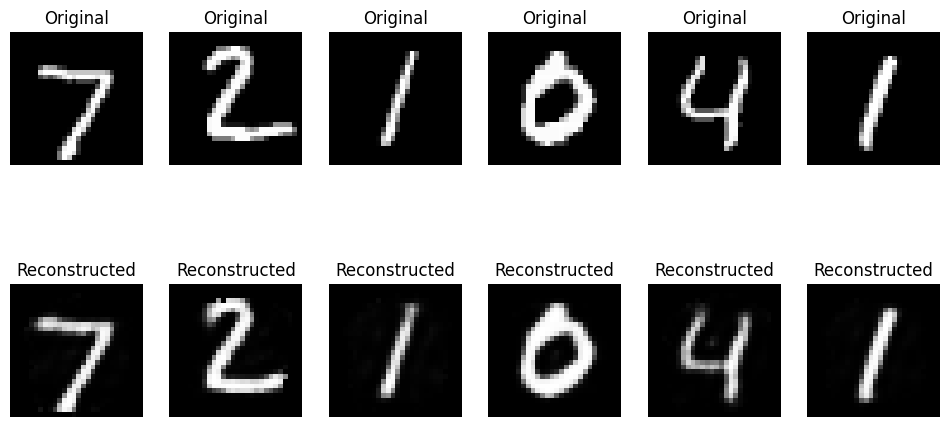

In [5]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 6
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [6]:
import torch
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torch import nn, optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

mnist_dataset_train = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
mnist_dataset_test = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

batch_size = 128

train_loader = torch.utils.data.DataLoader(
    mnist_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    mnist_dataset_test, batch_size=5, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]


In [8]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x):
        q = self.encode(x.view(-1, 784))
        return self.decode(q)

In [9]:
def train(epoch, model, train_loader, optimizer, cuda=True):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        data_noise = torch.randn(data.shape).to(device)
        data_noise = data + data_noise
        recon_batch = model(data_noise)
        loss = criterion(recon_batch, data.view(data.size(0), -1))
        loss.backward()
        train_loss += loss.item() * len(data)
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

In [15]:
epochs = 15
model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [16]:
for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, optimizer, True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.230809
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.128600
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.058230
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.054192
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.051769
====> Epoch: 1 Average loss: 0.0730
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.050406
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.052163
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.052593
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.049171
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.047305
====> Epoch: 2 Average loss: 0.0498
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.048679
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.045858
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.044771
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.046194
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.046703
====> Epoch: 3 Average loss: 0.0472
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.045903
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.048065
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.050379
Train Epoch:

 Image 0 with label 7 Image 1 with label 2 Image 2 with label 1 Image 3 with label 0 Image 4 with label 4

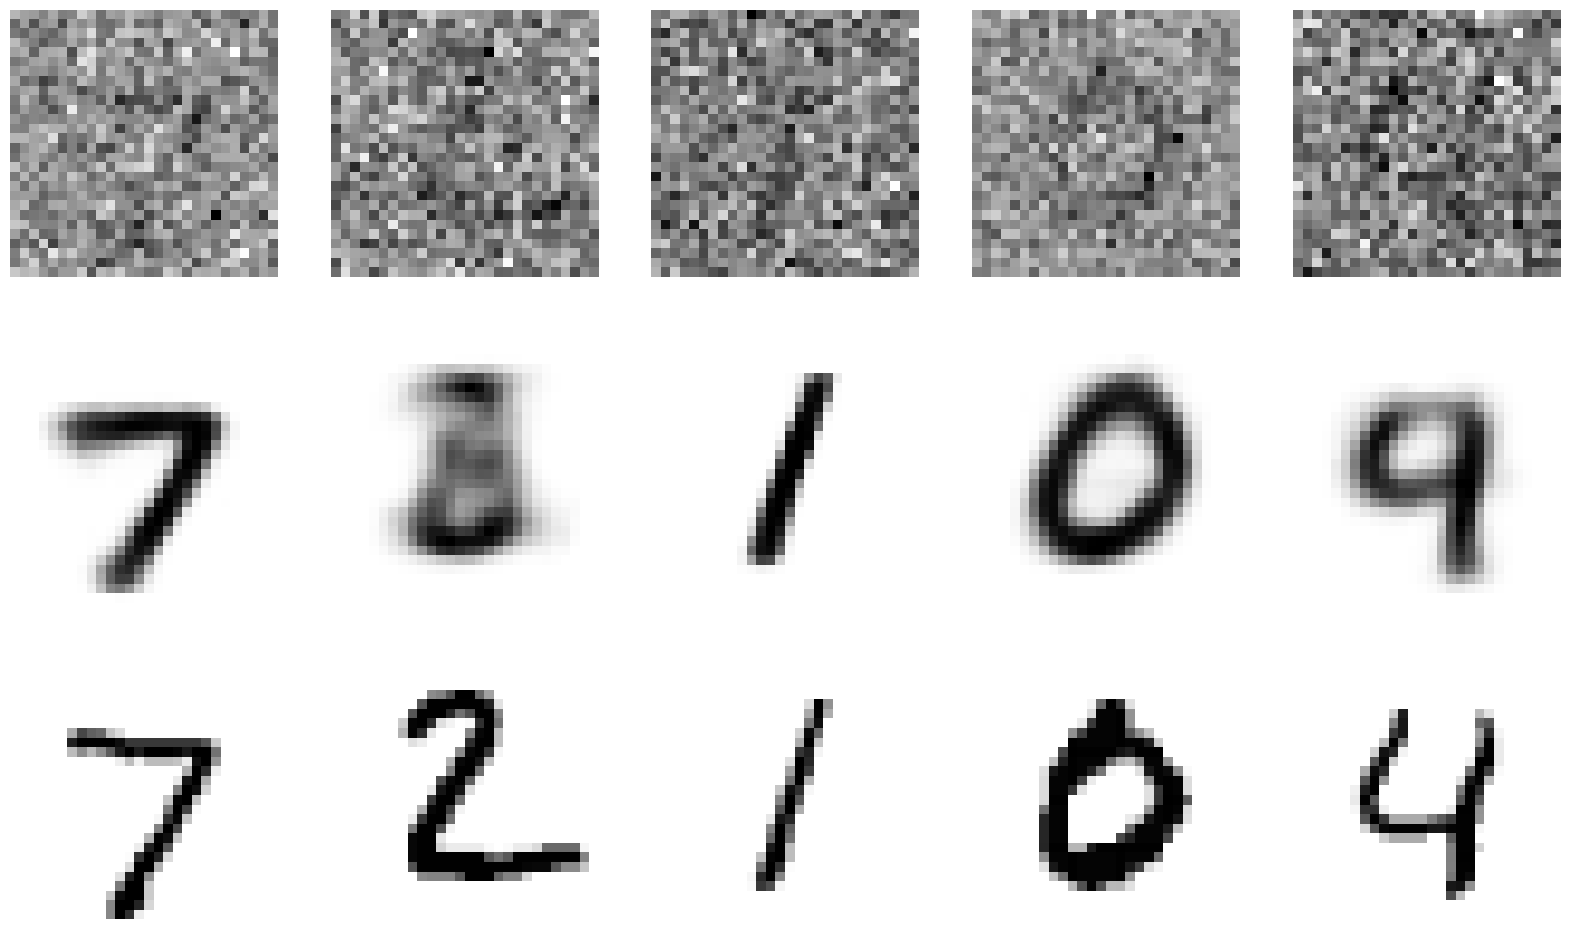

In [17]:
import matplotlib.pyplot as plt

for batch_idx, (data, labels) in enumerate(test_loader):
    data = data.to(device)
    optimizer.zero_grad()
    data_noise = torch.randn(data.shape).to(device)
    data_noise = data + data_noise
    recon_batch = model(data_noise)
    break

plt.figure(figsize=(20, 12))
for i in range(5):
    print(f" Image {i} with label {labels[i]}", end="")
    plt.subplot(3, 5, 1 + i)
    plt.imshow(data_noise[i, :, :, :].view(
        28, 28).cpu().detach().numpy(), cmap='binary')
    plt.axis('off')
    plt.subplot(3, 5, 6 + i)
    plt.imshow(recon_batch[i, :].view(
        28, 28).cpu().detach().numpy(), cmap='binary')
    plt.axis('off')
    plt.subplot(3, 5, 11 + i)
    plt.imshow(data[i, :, :, :].view(
        28, 28).cpu().detach().numpy(), cmap='binary')
    plt.axis('off')
plt.show()

Epoch 1/10, Loss: 0.044256
Epoch 2/10, Loss: 0.034534
Epoch 3/10, Loss: 0.034046
Epoch 4/10, Loss: 0.033949
Epoch 5/10, Loss: 0.033784
Epoch 6/10, Loss: 0.033755
Epoch 7/10, Loss: 0.033690
Epoch 8/10, Loss: 0.033651
Epoch 9/10, Loss: 0.033685
Epoch 10/10, Loss: 0.033635


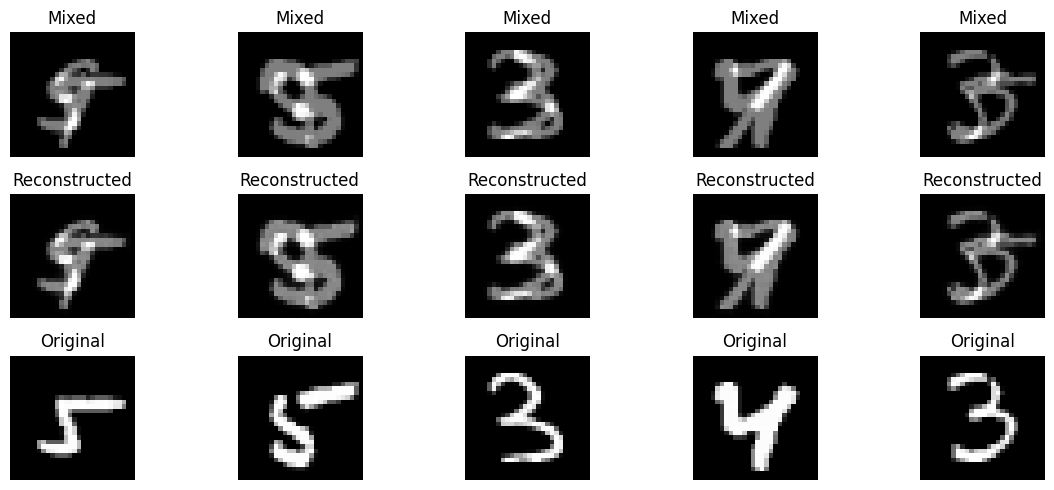

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------
# Dataset
# ----------------------------
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# ----------------------------
# Simple CNN Autoencoder
# ----------------------------
class DeepfakeAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = DeepfakeAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# Training for mixed images
# ----------------------------
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, _ in loader:
        data = data.to(device)

        # Pick random images in batch
        idx = torch.randperm(data.size(0))
        random_data = data[idx]

        # Mix two images
        mixed_input = 0.5*data + 0.5*random_data

        optimizer.zero_grad()
        output = model(mixed_input)
        loss = criterion(output, data) # target = original
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader.dataset):.6f}')

# ----------------------------
# Test & Visualization
# ----------------------------
model.eval()
with torch.no_grad():
    data, _ = next(iter(loader))
    data = data.to(device)
    idx = torch.randperm(data.size(0))
    random_data = data[idx]
    mixed_input = 0.5*data + 0.5*random_data
    output = model(mixed_input)

# Plot first 5 results
plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(mixed_input[i,0].cpu(), cmap='gray')
    plt.title("Mixed")
    plt.axis('off')

    plt.subplot(3,5,i+6)
    plt.imshow(output[i,0].cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    plt.subplot(3,5,i+11)
    plt.imshow(data[i,0].cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()


Using device: cuda
Epoch 1/10, Loss: 0.012464
Epoch 2/10, Loss: 0.001092
Epoch 3/10, Loss: 0.000592
Epoch 4/10, Loss: 0.000392
Epoch 5/10, Loss: 0.000303
Epoch 6/10, Loss: 0.000261
Epoch 7/10, Loss: 0.000237
Epoch 8/10, Loss: 0.000221
Epoch 9/10, Loss: 0.000210
Epoch 10/10, Loss: 0.000202


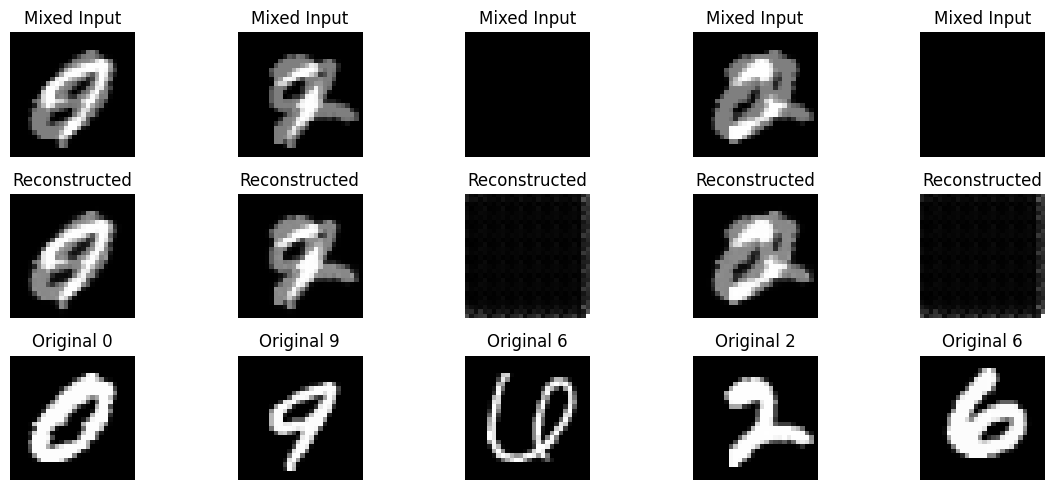

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ----------------------------
# Dataset
# ----------------------------
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# ----------------------------
# Hybrid / Deepfake Autoencoder
# ----------------------------
class HybridAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ----------------------------
# Model, Loss, Optimizer
# ----------------------------
model = HybridAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# Training: mix two different digits per batch
# ----------------------------
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)

        # Shuffle batch to pick different digits
        idx = torch.randperm(data.size(0))
        data2 = data[idx]
        labels2 = labels[idx]

        # Optionally, only mix different digits
        mask = (labels != labels2)
        if mask.sum() == 0:  # if all digits same, skip
            continue
        mixed_input = torch.zeros_like(data)
        mixed_input[mask] = 0.5 * data[mask] + 0.5 * data2[mask]

        optimizer.zero_grad()
        output = model(mixed_input)
        loss = criterion(output, mixed_input)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')

# ----------------------------
# Testing / Visualization
# ----------------------------
model.eval()
with torch.no_grad():
    data, labels = next(iter(test_loader))
    data = data.to(device)
    labels = labels.to(device)

    idx = torch.randperm(data.size(0))
    data2 = data[idx]
    labels2 = labels[idx]

    # Mix only different digits
    mask = (labels != labels2)
    mixed_input = torch.zeros_like(data)
    mixed_input[mask] = 0.5 * data[mask] + 0.5 * data2[mask]

    output = model(mixed_input)

# ----------------------------
# Plot first 5 results
# ----------------------------
plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(mixed_input[i,0].cpu().numpy(), cmap='gray')
    plt.title("Mixed Input")
    plt.axis('off')

    plt.subplot(3,5,i+6)
    plt.imshow(output[i,0].cpu().numpy(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    plt.subplot(3,5,i+11)
    plt.imshow(data[i,0].cpu().numpy(), cmap='gray')
    plt.title(f"Original {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Using device: cuda
Epoch 1/20, Loss: 0.008851
Epoch 2/20, Loss: 0.003765
Epoch 3/20, Loss: 0.002864
Epoch 4/20, Loss: 0.002298
Epoch 5/20, Loss: 0.001945
Epoch 6/20, Loss: 0.001762
Epoch 7/20, Loss: 0.001592
Epoch 8/20, Loss: 0.001431
Epoch 9/20, Loss: 0.001302
Epoch 10/20, Loss: 0.001221
Epoch 11/20, Loss: 0.001157
Epoch 12/20, Loss: 0.001055
Epoch 13/20, Loss: 0.001027
Epoch 14/20, Loss: 0.000954
Epoch 15/20, Loss: 0.000918
Epoch 16/20, Loss: 0.000901
Epoch 17/20, Loss: 0.000889
Epoch 18/20, Loss: 0.000807
Epoch 19/20, Loss: 0.000793
Epoch 20/20, Loss: 0.000767


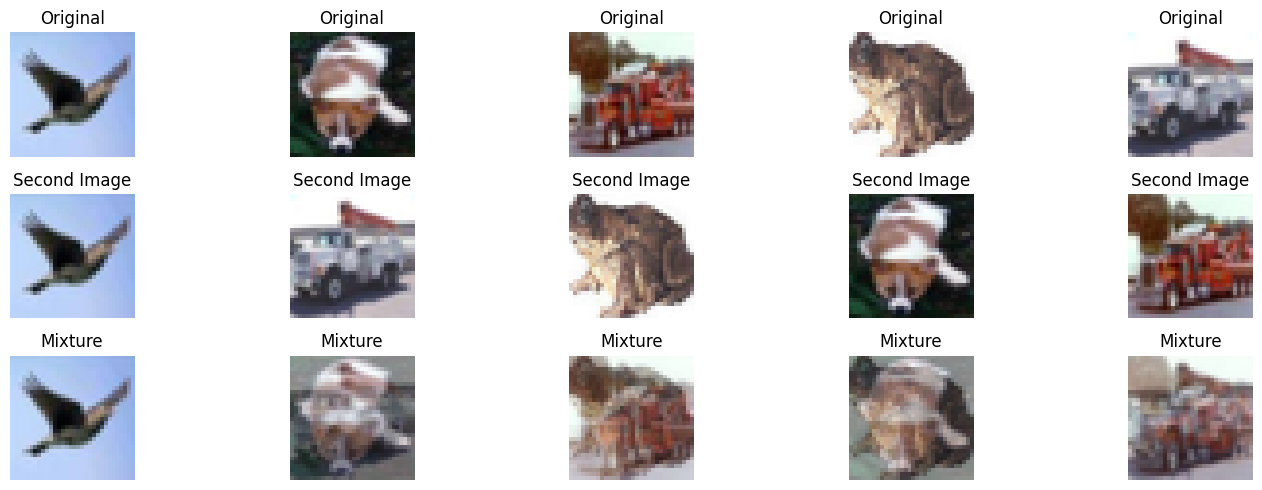

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ----------------------------
# CIFAR-10 Dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# ----------------------------
# Autoencoder for CIFAR-10
# ----------------------------
class CIFARHybridAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),   # 16x16 -> 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ----------------------------
# Model, Loss, Optimizer
# ----------------------------
model = CIFARHybridAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# Training: Mix two different images
# ----------------------------
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)

        # Shuffle batch to pick a second image
        idx = torch.randperm(data.size(0))
        data2 = data[idx]

        # Mix both images
        mixed_input = 0.5 * data + 0.5 * data2

        optimizer.zero_grad()
        output = model(mixed_input)
        loss = criterion(output, mixed_input)  # target = mixture
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')

# ----------------------------
# Testing / Visualization
# ----------------------------
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)

    # Pick second image
    idx = torch.randperm(data.size(0))
    data2 = data[idx]

    mixed_input = 0.5 * data + 0.5 * data2
    output = model(mixed_input)

# ----------------------------
# Plot first 5 results: Original, Second Image, Mixture
# ----------------------------
plt.figure(figsize=(15,5))
for i in range(5):
    # Original
    plt.subplot(3,5,i+1)
    plt.imshow(data[i].cpu().permute(1,2,0))
    plt.title("Original")
    plt.axis('off')

    # Second / Random Image
    plt.subplot(3,5,i+6)
    plt.imshow(data2[i].cpu().permute(1,2,0))
    plt.title("Second Image")
    plt.axis('off')

    # Mixture
    plt.subplot(3,5,i+11)
    plt.imshow(mixed_input[i].cpu().permute(1,2,0))
    plt.title("Mixture")
    plt.axis('off')

plt.tight_layout()
plt.show()


Using device: cuda
Epoch 1/10, Loss: 0.009125
Epoch 2/10, Loss: 0.003495
Epoch 3/10, Loss: 0.002647
Epoch 4/10, Loss: 0.002186
Epoch 5/10, Loss: 0.001865
Epoch 6/10, Loss: 0.001714
Epoch 7/10, Loss: 0.001533
Epoch 8/10, Loss: 0.001405
Epoch 9/10, Loss: 0.001274
Epoch 10/10, Loss: 0.001218


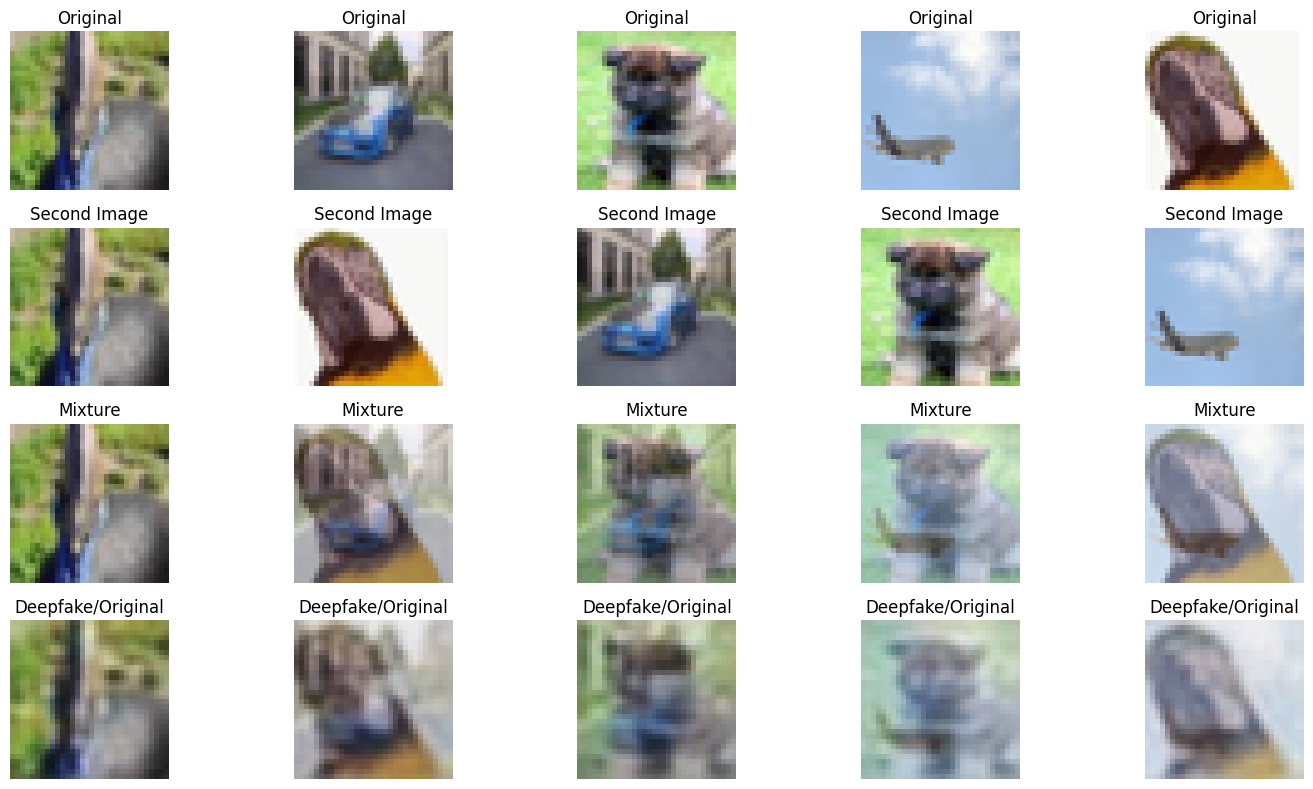

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ----------------------------
# CIFAR-10 Dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# ----------------------------
# Autoencoder for CIFAR-10
# ----------------------------
class CIFARHybridAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),   # 16x16 -> 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ----------------------------
# Model, Loss, Optimizer
# ----------------------------
model = CIFARHybridAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# Training: Mix two different images
# ----------------------------
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)

        # Shuffle batch to pick a second image
        idx = torch.randperm(data.size(0))
        data2 = data[idx]

        # Mix both images (treated as “true/original”)
        mixed_input = 0.5 * data + 0.5 * data2

        optimizer.zero_grad()
        output = model(mixed_input)
        loss = criterion(output, mixed_input)  # target = mixture (deepfake treated as original)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')

# ----------------------------
# Testing / Visualization
# ----------------------------
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)

    # Pick second image for mixing
    idx = torch.randperm(data.size(0))
    data2 = data[idx]

    mixed_input = 0.5 * data + 0.5 * data2
    output = model(mixed_input)

# ----------------------------
# Plot first 5 results: Original, Second Image, Mixture, Reconstructed (Deepfake)
# ----------------------------
plt.figure(figsize=(15,8))
for i in range(5):
    # Original
    plt.subplot(4,5,i+1)
    plt.imshow(data[i].cpu().permute(1,2,0))
    plt.title("Original")
    plt.axis('off')

    # Second Image
    plt.subplot(4,5,i+6)
    plt.imshow(data2[i].cpu().permute(1,2,0))
    plt.title("Second Image")
    plt.axis('off')

    # Mixed Input
    plt.subplot(4,5,i+11)
    plt.imshow(mixed_input[i].cpu().permute(1,2,0))
    plt.title("Mixture")
    plt.axis('off')

    # Autoencoder Output (Deepfake treated as original)
    plt.subplot(4,5,i+16)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.title("Deepfake/Original")
    plt.axis('off')

plt.tight_layout()
plt.show()


Using device: cuda
Epoch 1/20, Loss: 0.009327
Epoch 2/20, Loss: 0.003715
Epoch 3/20, Loss: 0.002832
Epoch 4/20, Loss: 0.002385
Epoch 5/20, Loss: 0.001976
Epoch 6/20, Loss: 0.001713
Epoch 7/20, Loss: 0.001590
Epoch 8/20, Loss: 0.001410
Epoch 9/20, Loss: 0.001304
Epoch 10/20, Loss: 0.001227
Epoch 11/20, Loss: 0.001152
Epoch 12/20, Loss: 0.001067
Epoch 13/20, Loss: 0.001010
Epoch 14/20, Loss: 0.000959
Epoch 15/20, Loss: 0.000919
Epoch 16/20, Loss: 0.000871
Epoch 17/20, Loss: 0.000827
Epoch 18/20, Loss: 0.000812
Epoch 19/20, Loss: 0.000782
Epoch 20/20, Loss: 0.000753


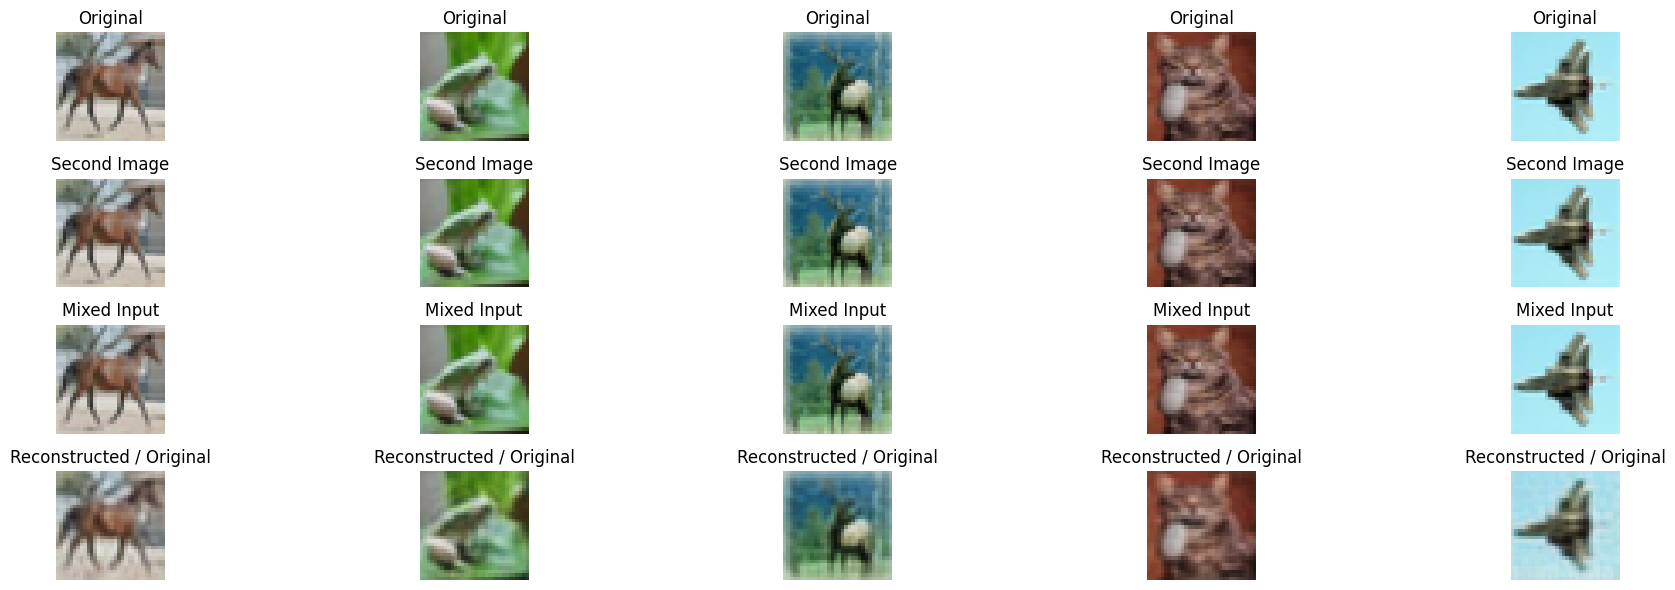

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ----------------------------
# CIFAR-10 Dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# ----------------------------
# Autoencoder for CIFAR-10
# ----------------------------
class CIFARHybridAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),   # 16x16 -> 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ----------------------------
# Model, Loss, Optimizer
# ----------------------------
model = CIFARHybridAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# Training: Mix two different images and treat mixture as "original"
# ----------------------------
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)

        # Shuffle batch to pick a second image
        idx = torch.randperm(data.size(0))
        data2 = data[idx]

        # Create mixed input
        mixed_input = 0.5 * data + 0.5 * data2

        # Autoencoder reconstructs mixed image
        optimizer.zero_grad()
        output = model(mixed_input)
        loss = criterion(output, mixed_input)  # target = mixed input
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')

# ----------------------------
# Testing / Visualization
# ----------------------------
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)

    # Pick second image
    idx = torch.randperm(data.size(0))
    data2 = data[idx]

    # Create mixed image
    mixed_input = 0.5 * data + 0.5 * data2

    # Autoencoder output treats mixture as original
    output = model(mixed_input)

# ----------------------------
# Plot first 5 results
# Original, Second Image, Mixed Input, Output (treated as original)
# ----------------------------
plt.figure(figsize=(20,6))
for i in range(5):
    # Original Image
    plt.subplot(4,5,i+1)
    plt.imshow(data[i].cpu().permute(1,2,0))
    plt.title("Original")
    plt.axis('off')

    # Second / Random Image
    plt.subplot(4,5,i+6)
    plt.imshow(data2[i].cpu().permute(1,2,0))
    plt.title("Second Image")
    plt.axis('off')

    # Mixed Input
    plt.subplot(4,5,i+11)
    plt.imshow(mixed_input[i].cpu().permute(1,2,0))
    plt.title("Mixed Input")
    plt.axis('off')

    # Autoencoder Output (Deepfake treated as original)
    plt.subplot(4,5,i+16)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.title("Reconstructed / Original")
    plt.axis('off')

plt.tight_layout()
plt.show()
